# 1D Heat Diffusion using Finite Difference Method

Heat diffusion is defined by the partial differential equation (known as the heat equation):

$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$

To solve this numerically, we will use the finite difrence method. First we discretize the above equation in space and time.

$$\frac{u_{new} - u_{old}}{\Delta t} = \alpha \frac{u_{old\_left} - 2u_{old} + u_{old\_right}}{\Delta x^2}$$

Solving explicitly might result in stability issues, so we will use the implicit method. The discretized equation is:

$$\frac{u_{new} - u_{old}}{\Delta t} = \alpha \frac{u_{new\_left} - 2u_{new} + u_{new\_right}}{\Delta x^2}$$

The problem with this, is that we do not have direct access to $u_{new}$, $u_{new\_left}$ and $u_{new\_right}$. However, we can solve this as a system of linear equations. The above equation can be written as:

$$u_{old} = u_{new} - \alpha \Delta t \frac{u_{new\_left} - 2u_{new} + u_{new\_right}}{\Delta x^2}$$

$$u_{old} = -\frac{\alpha \Delta t}{\Delta x^2}u_{new\_left} + (1 + \frac{2 \alpha \Delta t}{\Delta x^2}u_{new}) + -\frac{\alpha \Delta t}{\Delta x^2}u_{new\_right}   $$

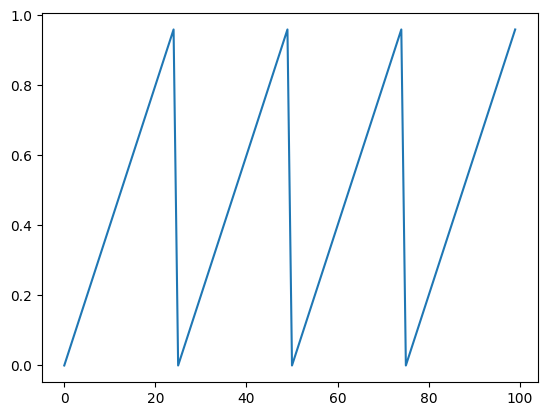

In [1]:
# Generate saw tooth wave
import numpy as np
from matplotlib import pyplot as plt
LENGTH = 100

def sawtooth_wave(samples, period, amplitude):
    sawtooth = []
    for i in range(samples):
        sawtooth.append(amplitude * (i % period) / period)
    return sawtooth

temp = sawtooth_wave(LENGTH, 25, 1)

plt.plot(temp)

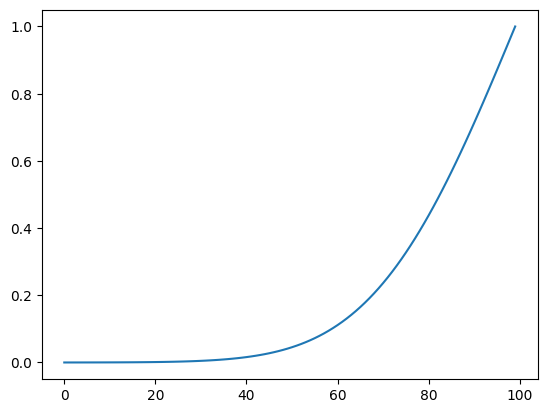

In [3]:
DELTA_T = 0.03
DELTA_X = 0.1
CONDUCTIVITY = 0.01

def step(temp):
    alpha = CONDUCTIVITY * DELTA_T / (DELTA_X ** 2)
    # Create matrix A and vector B
    A = np.zeros((LENGTH, LENGTH))
    B = np.zeros(LENGTH)

    # Set boundary conditions
    A[0][0] = 1
    A[LENGTH-1][LENGTH-1] = 1
    B[0] = 0
    B[LENGTH-1] = 1

    # Set the rest of the matrix
    for i in range(1, LENGTH-1):
        A[i][i-1] = -alpha
        A[i][i] = 1 + 2 * alpha
        A[i][i+1] = -alpha
        B[i] = temp[i]

    # Solve the system
    solution = np.linalg.solve(A, B)

    return solution

SAVE_FREQUENCY = 50
historical_temps = []

for i in range(10000):
    if i % SAVE_FREQUENCY == 0:
        historical_temps.append(temp)
    temp = step(temp)

plt.plot(temp)

In [ ]:
# Plot all historical temperatures varying the color from blue to red
for i in range(len(historical_temps)):
    plt.plot(historical_temps[i], color=(0, 0, i / len(historical_temps)))

In [10]:
# Create an animation
import os
os.makedirs("output", exist_ok=True)

for i in range(len(historical_temps)):
    plt.figure(figsize=(10, 10))
    plt.plot(historical_temps[i], color="black")
    plt.title(f"Step {i * SAVE_FREQUENCY}")
    plt.ylabel("Temperature")
    plt.xlabel("Position")
    plt.tight_layout()
    plt.savefig(f"output/{i:03d}.png")
    plt.close()

In [ ]:
# Use ffmpeg to create a video. Start with making the intro using only the first frame for 3 seconds
!ffmpeg -y -framerate 0.2 -i output/000.png -c:v libx264 -r 30 -pix_fmt yuv420p output/intro.mp4
# Then create the video
!ffmpeg -y -framerate 30 -i output/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p output/animation.mp4
# Concatenate the intro and the video
!ffmpeg -y -i output/intro.mp4 -i output/animation.mp4 -filter_complex "[0:v] [1:v] concat=n=2:v=1 [v]" -map "[v]" output/output.mp4